In [26]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [27]:
import pandas as pd

df = pd.read_csv("data/ExtractedTweets.csv")
df.head()

democrats = df.query("Party == 'Democrat'").sample(10000)
republican = df.query("Party == 'Republican'").sample(10000)

df_slim = democrats.append(republican)
df_slim.head()
df = df_slim

### Extract tweet information

In [28]:
import re

def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

# make new columns for retweeted usernames, mentioned usernames and hashtags
df['retweeted'] = df['Tweet'].apply(find_retweeted)
df['mentioned'] = df['Tweet'].apply(find_mentioned)
df['hashtags'] = df['Tweet'].apply(find_hashtags)
df.head(30)

print("Extracted tweet metadata")

Extracted tweet metadata


### Clean metioned, retweets and hashtags from tweet

In [29]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.append("rt")

def clean_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.sub('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.sub('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean(tweet):
    # Remove mentions, retweets and hashtags
    tweet = clean_hashtags(tweet)
    tweet = clean_mentioned(tweet)
    tweet = clean_retweeted(tweet)
    tweet = tweet.lower()
    # Remove punctuation
    tweet = re.sub("[\\.,;:!/\\?]*", "", tweet)
    # Remove links
    tweet = re.sub(r"http\S+", "", tweet)
    # Remove stop words
    tweet = ' '.join([word for word in tweet.split(' ') if not word in stop_words])
    # Remove multiple spaces
    tweet = re.sub("\\s+", " ", tweet)
    return tweet

df['TweetCleaned'] = df['Tweet'].apply(clean)
df.head()

print("Cleaned tweets")

[nltk_data] Downloading package stopwords to /home/lennarth/Documents/
[nltk_data]     GitHub/nlp_project/venv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaned tweets


### Lemmatize the text

In [30]:
import spacy
# python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatization(tweet, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    doc = nlp(tweet)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    return final

df['TweetCleaned'] = df['TweetCleaned'].apply(lemmatization)
df.head()
print("Lemmatized tweets")

Lemmatized tweets


In [31]:
import gensim

def gen_words(tweet):
    # Use gensims simple simple_preprocess to remove accents, lowercase and tokenize
    return gensim.utils.simple_preprocess(tweet, deacc=True)

df['TweetWords'] = df['TweetCleaned'].apply(gen_words)
df.head()

print("Generated tokens")

Generated tokens


In [32]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(df['TweetWords'], min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[df['TweetWords']], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(tweetWords):
    return bigram[tweetWords]

def make_trigrams(bigrams):
    return trigram[bigram[bigrams]]

df['bigramms'] =  df['TweetWords'].apply(make_bigrams)
df['trigrams'] = df['bigramms'].apply(make_trigrams)
df.head(30)

print("Generated trigrams")

Generated trigrams


### TF-IDF REMOVAL

In [47]:
from gensim.models import TfidfModel
import gensim.corpora as corpora

id2word = corpora.Dictionary(df['trigrams'])

corpus = [id2word.doc2bow(text) for text in df['trigrams']]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.20
words  = []
words_missing_in_tfidf = []

for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] # reinitialize to be safe.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf score 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

# TODO: remove empty entries

print("TF-IDF removal")
print("Finish preprocessing")

TF-IDF removal
Finish preprocessing


In [9]:
import pickle
file = open("data.bin", "wb")
pickle.dump((df, id2word, corpus, tfidf), file)

In [10]:
import pickle
(df, id2word, corpus, tfidf) = pickle.load(open("data.bin", "rb"))

In [13]:
def get_document_topic(model, tri):
    doc_bow = id2word.doc2bow(tri)
    vec = model.get_document_topics(bow=doc_bow, minimum_probability=0)
    return [v for _, v in vec]

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

def evaluate_model(model):
    df['topic_vec'] = df['trigrams'].apply(lambda trigram: get_document_topic(model, trigram))
    df['len'] = df['topic_vec'].apply(lambda x: len(x))

    result = {}

    text_train, text_test, label_train, label_test = train_test_split(df["topic_vec"], df['Party'], train_size=0.70, random_state=101, test_size=0.30, shuffle=True)
    classifiers = [('MLP', MLPClassifier()), ('G-NB', GaussianNB()), ('L-SVM', LinearSVC())]
    for name, cl in classifiers:

        # Train and predict
        cl.fit(text_train.to_list(), label_train)

        prediction = cl.predict(text_test.to_list())

        # Confusion matrix
        confusion = confusion_matrix(label_test, prediction)
        # increase size of plot and fontsize for improved visibility
        #fig, ax_cm = plt.subplots(figsize=(10, 10))
        #plt.rcParams.update({'font.size': 14})
        # create plot for multi-class confusion matrix, use prepared axes object and change colormap for better contrast
        #plot_confusion_matrix(cl, text_test.to_list(), label_test.to_list(), ax=ax_cm, cmap=plt.cm.Reds_r)
        # show plot corresponding to printed name and accuracy
        #plt.show()
        accuracy = accuracy_score(label_test, prediction)
        precision, recall, fscore, *rest = precision_recall_fscore_support(label_test, prediction, average='macro')
        result[name] = confusion, accuracy, precision, recall, fscore
    return result

In [15]:
import gensim
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    perplexitiy_values = []
    model_list = []
    evaluations = []
    for num_topics in range(start, limit, step):
        print("Generated model with " + str(num_topics) + " topics")
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=100,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        perplexity = model.log_perplexity(corpus)
        print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.
        #coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        #coherence_values.append(coherencemodel.get_coherence())
        evaluation = evaluate_model(model)
        evaluations.append(evaluation)
        perplexitiy_values.append(perplexity)
        #print("Coherence: " + str(coherencemodel.get_coherence()))
        print("Evaluation: " + str(evaluation))

    return model_list, perplexitiy_values, evaluations


In [16]:
limit=200
start=2
step=5

model_list, perplexitiy_values, evaluations = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['trigrams'], start=start, limit=limit, step=step)

Generated model with 2 topics
Perplexity:  -8.073199889649953
Evaluation: {'MLP': (array([[2830, 3224],
       [2568, 3378]]), 0.5173333333333333, 0.5179656899415999, 0.5177862740215291, 0.5163246552727572), 'G-NB': (array([[2066, 3988],
       [1777, 4169]]), 0.5195833333333333, 0.5243477989575578, 0.5212028007601949, 0.504360989237863), 'L-SVM': (array([[2830, 3224],
       [2570, 3376]]), 0.5171666666666667, 0.5177946127946127, 0.517618093732259, 0.5161650072729735)}
Generated model with 7 topics
Perplexity:  -8.45074431103706
Evaluation: {'MLP': (array([[2895, 3159],
       [2196, 3750]]), 0.55375, 0.5557104297103187, 0.5544361593289056, 0.5514730247773463), 'G-NB': (array([[2674, 3380],
       [1986, 3960]]), 0.5528333333333333, 0.5566646396370057, 0.5538426945915953, 0.5476380950769857), 'L-SVM': (array([[3151, 2903],
       [2547, 3399]]), 0.5458333333333333, 0.5461768197407677, 0.5460635644820564, 0.5456392708174468)}
Generated model with 12 topics
Perplexity:  -9.7237527618732

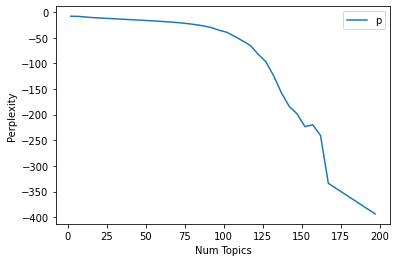

In [17]:
import matplotlib.pyplot as plt

# Create Perplexity Plot for topic numbers
x = range(start, limit, step)
plt.plot(x, perplexitiy_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend("perplexitiy_values", loc='best')
plt.savefig("img/topic_count.pdf")
plt.show()

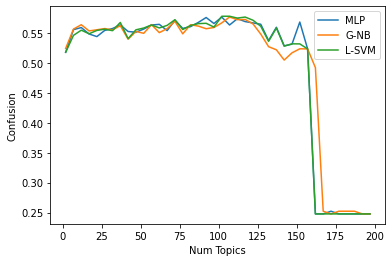

In [18]:
# Create classifier comparision for multiple scores
# Hint: You need to change the respective variables in line 8 and the figure labels
scores = {name: [] for name in evaluations[0].keys()}
for evaluation in evaluations:
    for name, ev in evaluation.items():
    # evaluation: confusion, accuracy, precision, recall, fscore
        confusion, accuracy, precision, recall, fscore = ev
        scores[name].append(precision)

for label, score in scores.items():
    plt.plot(x, score, label = label)
plt.xlabel("Num Topics")
plt.ylabel("Confusion")
plt.legend()
plt.savefig("img/topic_confusion.pdf")
plt.show()

In [19]:
# Create a summary for each classifier

names = evaluations[0].keys()
x = range(0, 200, 5)
print(x)
plt.clf()

# Create summary figure for all classifiers separately
for name in names:
    f1 = []
    acc = []
    pre = []
    rec = []
    evs = []

    for evaluation in evaluations:
        for inner_name, ev in evaluation.items():
            if inner_name == name:
                evs.append(ev)
    for ev in evs[:40]:
    # evaluation: confusion, accuracy, precision, recall, fscore
        confusion, accuracy, precision, recall, fscore = ev

        f1.append(fscore)
        acc.append(accuracy)
        pre.append(precision)
        rec.append(recall)
    plt.plot(x, f1, label = 'F1')
    plt.plot(x, acc, label = 'Accuracy')
    plt.plot(x, pre, label = 'Precision')
    plt.plot(x, rec, label = 'Recall')
    plt.xlabel("Num Topics")
    plt.ylabel("")
    plt.legend()
    plt.savefig("img/summary_" + name.lower() + ".pdf")
    plt.clf()

range(0, 200, 5)


<Figure size 432x288 with 0 Axes>

In [48]:
import gensim
# Figures show 130 topics are the sweet spot
# TODO: parameters
lda_model = gensim.models.LdaMulticore(
                corpus=corpus[:-1],
                id2word=id2word,
                num_topics=105,
                random_state=100,
                chunksize=100,
                passes=10,
                workers=4
            )

Training classifier
Confusion:
 [[1541 1466]
 [1283 1710]]
Accuracy: 0.5418333333333333
Precision: 0.5420464924611641
Recall: 0.5419020059109211
F1Score: 0.5414695531085093


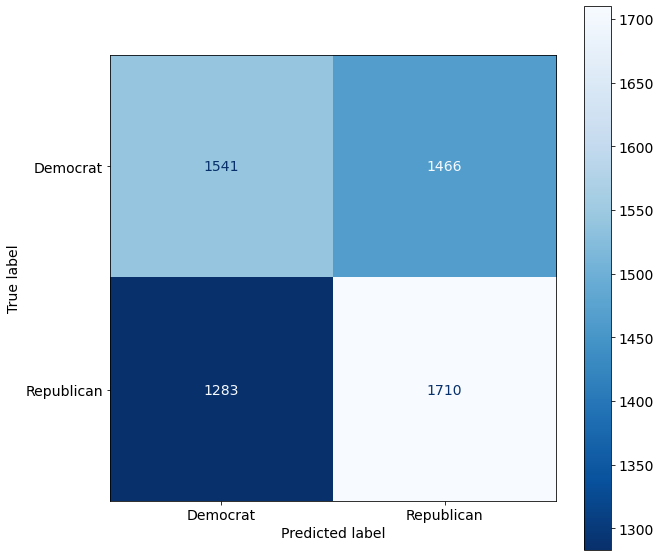

In [49]:
# Rerun the classifier on the new dataset

df['topic_vec'] = df['trigrams'].apply(lambda trigram: get_document_topic(lda_model, trigram))
df['len'] = df['topic_vec'].apply(lambda x: len(x))

print('Training classifier')
text_train, text_test, label_train, label_test = train_test_split(df["topic_vec"], df['Party'], train_size=0.70, random_state=101, test_size=0.30, shuffle=True)
cl = LinearSVC()
# Train and predict
cl.fit(text_train.to_list(), label_train)
prediction = cl.predict(text_test.to_list())
# Confusion matrix
confusion = confusion_matrix(label_test, prediction)
accuracy = accuracy_score(label_test, prediction)
precision, recall, fscore, *rest = precision_recall_fscore_support(label_test, prediction, average='macro')

print("Confusion:\n " + str(confusion))
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1Score: " + str(fscore))
# increase size of plot and fontsize for improved visibility
fig, ax_cm = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 14})
# create plot for multi-class confusion matrix, use prepared axes object and change colormap for better contrast
plot_confusion_matrix(cl, text_test.to_list(), label_test.to_list(), ax=ax_cm, cmap=plt.cm.Blues_r)
# show plot corresponding to printed name and accuracy
plt.savefig("img/lvm_summary_130.pdf")
plt.show()

In [50]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/lennarth/Documents/GitHub/nlp_project/

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
49     0.154176  0.537196       1        1  3.441612
68     0.349543  0.430269       2        1  3.264763
100   -0.206289  0.503557       3        1  3.187262
123   -0.053205  0.553461       4        1  3.109703
44     0.544013  0.020960       5        1  2.563446
...         ...       ...     ...      ...       ...
46     0.005051 -0.030552     126        1  0.306054
45     0.005051 -0.030552     127        1  0.306054
42     0.005051 -0.030552     128        1  0.306054
41     0.005051 -0.030552     129        1  0.306054
65     0.005051 -0.030552     130        1  0.306054

[130 rows x 5 columns], topic_info=          Term         Freq        Total  Category  logprob  loglift
189       work  1056.000000  1056.000000   Default  30.0000  30.0000
17         day   927.000000   927.000000   Default  29.0000  29.0000
424     people   910.000000   910.000000   Default  28.0000  28.0000
251       need  1015.000000  1015.000000   Default  27.0000  27.0000
95       woman   951.000000   951.000000   Default  26.0000  26.0000
..         ...          ...          ...       ...      ...      ...
21       local     0.035098   410.092215  Topic130  -9.3428  -3.5768
22     receive     0.035098   369.710052  Topic130  -9.3428  -3.4732
24   valentine     0.035098    24.748245  Topic130  -9.3428  -0.7692
25         vet     0.035098   129.497747  Topic130  -9.3428  -2.4241
28      school     0.035098   793.964469  Topic130  -9.3428  -4.2375

[5875 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1270     35  0.945389  ability
99       34  0.976915     able
777      37  0.991701   access
56        9  0.993856      act
246       4  0.991030   action
...     ...       ...      ...
1022      6  0.816446    wound
51        8  0.994428     year
691      26  0.293484    young
691      33  0.695243    young
1796     15  0.973408    youth

[409 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[50, 69, 101, 124, 45, 114, 91, 61, 82, 31, 57, 72, 68, 100, 21, 98, 49, 19, 7, 36, 32, 108, 122, 12, 17, 44, 111, 81, 13, 15, 130, 55, 90, 16, 30, 18, 56, 59, 64, 62, 128, 113, 89, 123, 92, 125, 110, 126, 127, 88, 87, 86, 85, 84, 83, 129, 93, 121, 94, 115, 107, 106, 80, 104, 103, 102, 116, 117, 118, 119, 99, 120, 109, 97, 96, 95, 112, 105, 1, 79, 23, 37, 35, 34, 33, 29, 28, 27, 26, 25, 24, 22, 39, 20, 14, 11, 10, 9, 8, 6, 5, 4, 3, 38, 40, 78, 63, 77, 76, 75, 74, 73, 71, 70, 67, 2, 65, 60, 41, 58, 54, 53, 52, 51, 48, 47, 46, 43, 42, 66])